In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, accuracy_score, precision_score, recall_score)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

LOAD PREPROCESSED DATA

In [3]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [4]:
# For autoencoder, we train ONLY on normal transactions
X_train_normal = X_train[y_train == 0]
X_train_fraud = X_train[y_train == 1]

In [5]:
print(f"Normal training samples: {X_train_normal.shape[0]}")
print(f"Fraud training samples: {X_train_fraud.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Normal training samples: 227451
Fraud training samples: 394
Test samples: 56962
Number of features: 30


BUILD AUTOENCODER MODEL

In [6]:
def create_autoencoder(input_dim, encoding_dim=14):
    """
    Creates an autoencoder with:
    - Encoder: compresses input to lower dimension
    - Decoder: reconstructs original input
    - Bottleneck: learns compressed representation
    """
    
    # Input layer
    input_layer = Input(shape=(input_dim,))
    
    # Encoder
    encoded = Dense(24, activation='relu')(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(20, activation='relu')(encoded)
    encoded = Dropout(0.2)(encoded)
    
    # Bottleneck (compressed representation)
    encoded = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)
    
    # Decoder
    decoded = Dense(20, activation='relu')(encoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(24, activation='relu')(decoded)
    decoded = Dropout(0.2)(decoded)
    
    # Output layer (reconstruction)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    # Create autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    
    return autoencoder

In [7]:
# Create model
input_dim = X_train.shape[1]
autoencoder = create_autoencoder(input_dim, encoding_dim=14)

In [8]:
# Display model architecture
print("\nAutoencoder Architecture:")
autoencoder.summary()


Autoencoder Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 14)             │           294 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │           504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │           750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,092 (12.08 KB)

 Trainable params: 3,092 (12.08 KB)

 Non-trainable params: 0 (0.00 B)

COMPILE MODEL

In [9]:
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

SETUP CALLBACKS

In [10]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'autoencoder_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, checkpoint]

TRAIN AUTOENCODER

In [13]:
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5817 - mae: 0.5077
Epoch 1: val_loss did not improve from 0.45852
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5836 - mae: 0.5074 - val_loss: 0.4631 - val_mae: 0.4575
Epoch 2/50
704/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5806 - mae: 0.5076
Epoch 2: val_loss did not improve from 0.45852
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5780 - mae: 0.5069 - val_loss: 0.4586 - val_mae: 0.4567
Epoch 3/50
700/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5815 - mae: 0.5074
Epoch 3: val_loss improved from 0.45852 to 0.45334, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5785 - mae: 0.5065 - val_loss: 0.4533 - val_mae: 0.4554
Epoch 4/50
697/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5803 - mae: 0.5069
Epoch 4: val_loss did not improve from 0.45334
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5833 - mae: 0.5067 - val_loss: 0.4597 - val_mae: 0.4571
Epoch 5/50
708/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5815 - mae: 0.5065
Epoch 5: val_loss did not improve from 0.45334
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5800 - mae: 0.5061 - val_loss: 0.4538 - val_mae: 0.4546
Epoch 6/50
702/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5763 - mae: 0.5056
Epoch 6: val_loss did not improve from 0.45334
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5744 - mae: 0.5051 - val_loss: 0.4536 - val_mae: 0.4553
Epoch 7/50
697/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5736 - mae: 0.5049
Epoch 7: val_loss did not improve from 0.45334
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5728 - ma

711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5784 - mae: 0.5049 - val_loss: 0.4497 - val_mae: 0.4528
Epoch 9/50
708/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5769 - mae: 0.5049
Epoch 9: val_loss did not improve from 0.44970
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5736 - mae: 0.5043 - val_loss: 0.4557 - val_mae: 0.4541
Epoch 10/50
702/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5785 - mae: 0.5049
Epoch 10: val_loss did not improve from 0.44970
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5762 - mae: 0.5044 - val_loss: 0.4546 - val_mae: 0.4540
Epoch 11/50
707/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5723 - mae: 0.5037
Epoch 11: val_loss did not improve from 0.44970
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5729 - mae: 0.5036 - val_loss: 0.4537 - val_mae: 0.4544
Epoch 12/50
698/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5714 - mae: 0.5036
Epoch 12: val_loss did not improve from 0.44970
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.571

711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5750 - mae: 0.5025 - val_loss: 0.4472 - val_mae: 0.4514
Epoch 15/50
706/711 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5759 - mae: 0.5036
Epoch 15: val_loss improved from 0.44716 to 0.44505, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5770 - mae: 0.5029 - val_loss: 0.4451 - val_mae: 0.4505
Epoch 16/50
703/711 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5706 - mae: 0.5030
Epoch 16: val_loss did not improve from 0.44505
711/711 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5697 - mae: 0.5026 - val_loss: 0.4480 - val_mae: 0.4523
Epoch 17/50
704/711 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5721 - mae: 0.5029
Epoch 17: val_loss did not improve from 0.44505
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5714 - mae: 0.5024 - val_loss: 0.4567 - val_mae: 0.4547
Epoch 18/50
709/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5721 - mae: 0.5030
Epoch 18: val_loss did not improve from 0.44505
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5702 - mae: 0.5022 - val_loss: 0.4507 - val_mae: 0.4522
Epoch 19/50
702/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5701 - mae: 0.5023
Epoch 19: val_loss did not improve from 0.44505
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5

711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5670 - mae: 0.5016 - val_loss: 0.4423 - val_mae: 0.4497
Epoch 25/50
699/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5651 - mae: 0.5018
Epoch 25: val_loss did not improve from 0.44231
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5665 - mae: 0.5015 - val_loss: 0.4509 - val_mae: 0.4522
Epoch 26/50
702/711 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5682 - mae: 0.5018
Epoch 26: val_loss did not improve from 0.44231
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5678 - mae: 0.5014 - val_loss: 0.4460 - val_mae: 0.4508
Epoch 27/50
709/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5717 - mae: 0.5018
Epoch 27: val_loss did not improve from 0.44231
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5689 - mae: 0.5013 - val_loss: 0.4493 - val_mae: 0.4510
Epoch 28/50
698/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5652 - mae: 0.5015
Epoch 28: val_loss did not improve from 0.44231
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5

711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5655 - mae: 0.5007 - val_loss: 0.4395 - val_mae: 0.4481
Epoch 33/50
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5661 - mae: 0.5012
Epoch 33: val_loss did not improve from 0.43948
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5646 - mae: 0.5006 - val_loss: 0.4443 - val_mae: 0.4497
Epoch 34/50
700/711 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5654 - mae: 0.5007
Epoch 34: val_loss did not improve from 0.43948
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5643 - mae: 0.5006 - val_loss: 0.4459 - val_mae: 0.4513
Epoch 35/50
701/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5664 - mae: 0.5013
Epoch 35: val_loss did not improve from 0.43948
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5654 - mae: 0.5004 - val_loss: 0.4518 - val_mae: 0.4519
Epoch 36/50
700/711 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5691 - mae: 0.5009
Epoch 36: val_loss did not improve from 0.43948
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5

PLOT TRAINING HISTORY

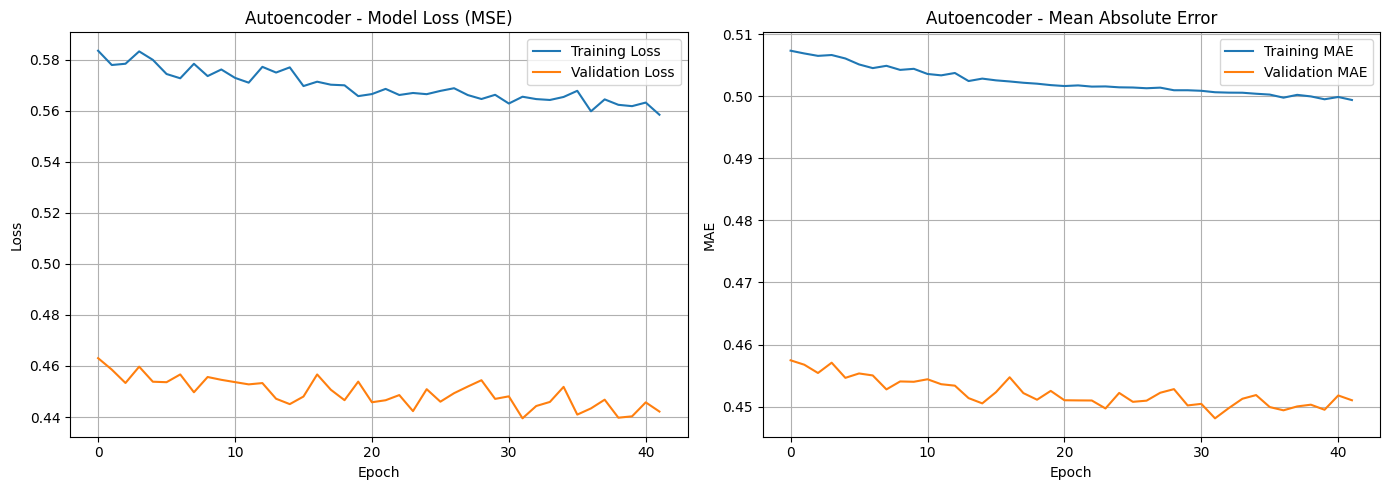

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Autoencoder - Model Loss (MSE)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_title('Autoencoder - Mean Absolute Error')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('autoencoder_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

CALCULATE RECONSTRUCTION ERRORS

In [15]:
# Get reconstructions
X_train_normal_pred = autoencoder.predict(X_train_normal, verbose=0)
X_train_fraud_pred = autoencoder.predict(X_train_fraud, verbose=0)
X_test_pred = autoencoder.predict(X_test, verbose=0)

# Calculate reconstruction errors (MSE)
train_normal_errors = np.mean(np.square(X_train_normal - X_train_normal_pred), axis=1)
train_fraud_errors = np.mean(np.square(X_train_fraud - X_train_fraud_pred), axis=1)
test_errors = np.mean(np.square(X_test - X_test_pred), axis=1)

print(f"\nNormal transactions - Mean reconstruction error: {train_normal_errors.mean():.6f}")
print(f"Fraud transactions - Mean reconstruction error: {train_fraud_errors.mean():.6f}")



Normal transactions - Mean reconstruction error: 0.440214
Fraud transactions - Mean reconstruction error: 20.193617


VISUALIZE RECONSTRUCTION ERRORS

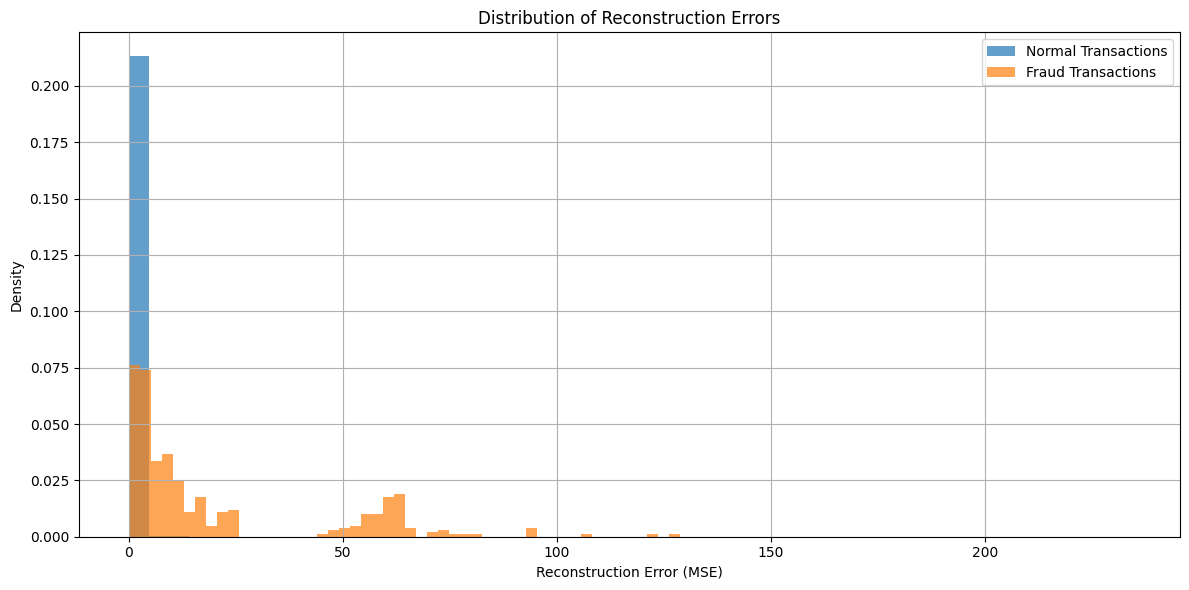

In [16]:
plt.figure(figsize=(12, 6))

plt.hist(train_normal_errors, bins=50, alpha=0.7, label='Normal Transactions', density=True)
plt.hist(train_fraud_errors, bins=50, alpha=0.7, label='Fraud Transactions', density=True)
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Density')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('autoencoder_reconstruction_errors.png', dpi=300, bbox_inches='tight')
plt.show()

FIND OPTIMAL THRESHOLD

In [17]:
# Try different thresholds
thresholds = np.percentile(train_normal_errors, np.arange(90, 100, 0.5))
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (test_errors > threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nOptimal threshold: {best_threshold:.6f}")
print(f"Best F1-Score: {best_f1:.4f}")


Optimal threshold: 3.813386
Best F1-Score: 0.3212


In [18]:
# Use optimal threshold for predictions
y_pred = (test_errors > best_threshold).astype(int)
y_pred_prob = test_errors  # Use reconstruction error as confidence score

EVALUATE MODEL

In [19]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, test_errors)

print(f"\nTest Set Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}")


Test Set Performance:
Accuracy:  0.9944
Precision: 0.2033
Recall:    0.7653
F1-Score:  0.3212
ROC-AUC:   0.9611
